# Biscuit Classification using Vision Transformer

## EDA

### Load the Dataset

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset

class BiscuitDataset(Dataset):
    def __init__(self, images_dict, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = list(images_dict.keys())
        self.class_to_label = {cls: idx for idx, cls in enumerate(self.classes)}
        for label, (biscuit_type, images) in enumerate(images_dict.items()):
            self.images.extend(images)
            self.labels.extend([self.class_to_label[biscuit_type]] * len(images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to RGB
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# Function to load the dataset
def load_dataset(dataset_path):
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path '{dataset_path}' does not exist.")
    
    biscuits_images = {}
    for biscuit_type in os.listdir(dataset_path):
        biscuit_path = os.path.join(dataset_path, biscuit_type)
        if os.path.isdir(biscuit_path):
            biscuits_images[biscuit_type] = []
            for image_name in os.listdir(biscuit_path):
                image_path = os.path.join(biscuit_path, image_name)
                try:
                    image = Image.open(image_path)
                    biscuits_images[biscuit_type].append(image)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    return biscuits_images

# Load the dataset
dataset_path = 'biscuits'
biscuits_images = load_dataset(dataset_path)

### Display the Dataset

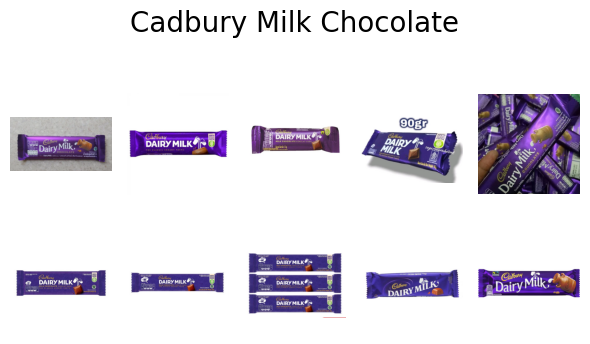

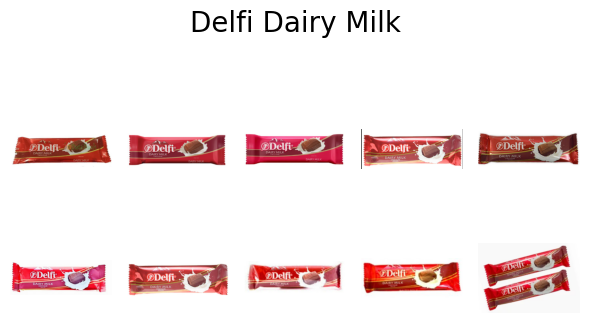

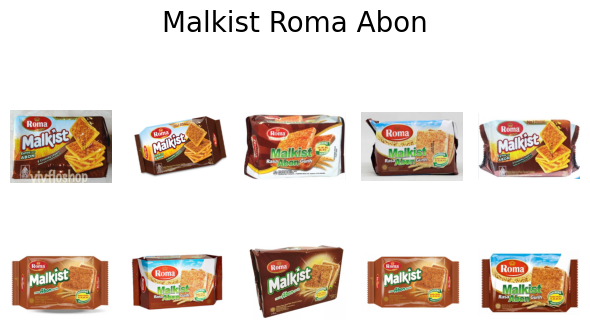

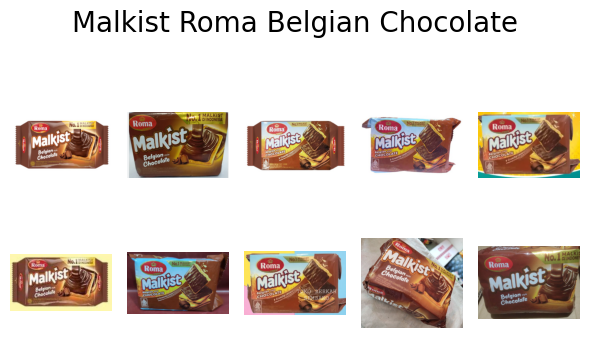

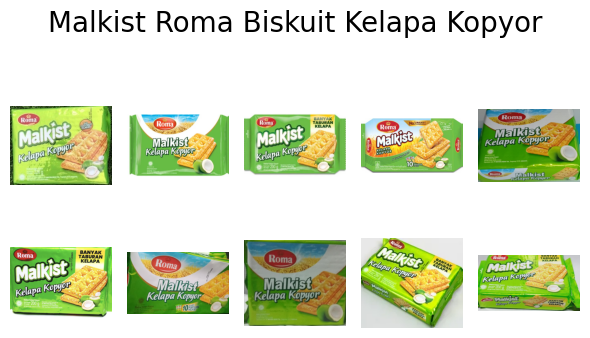

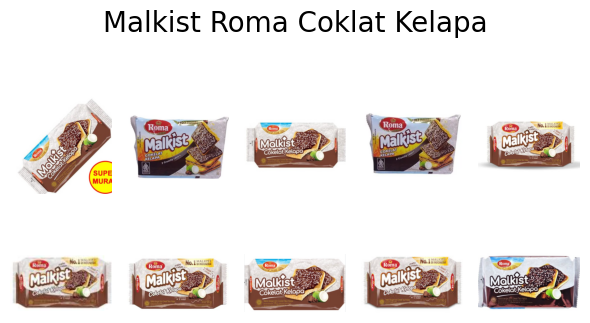

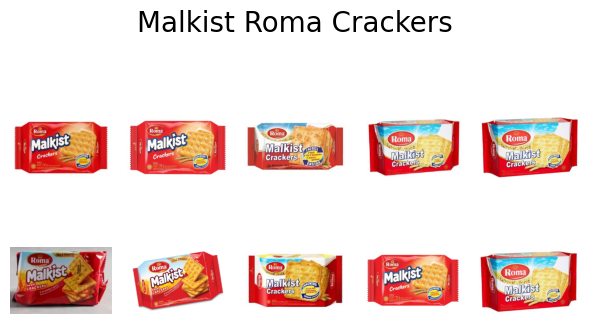

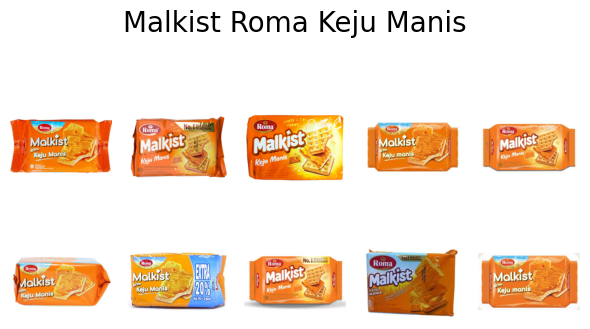

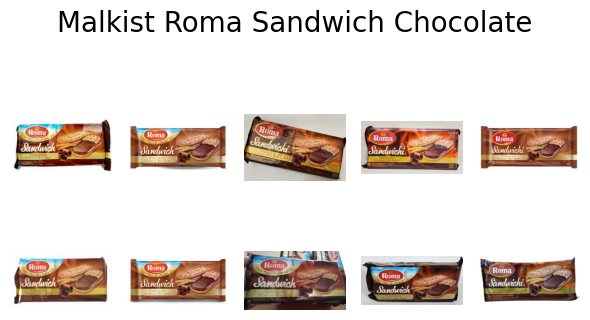

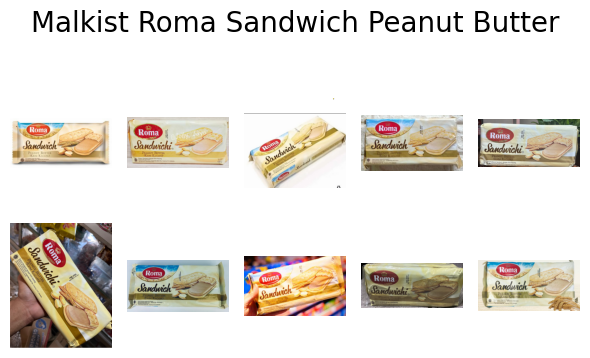

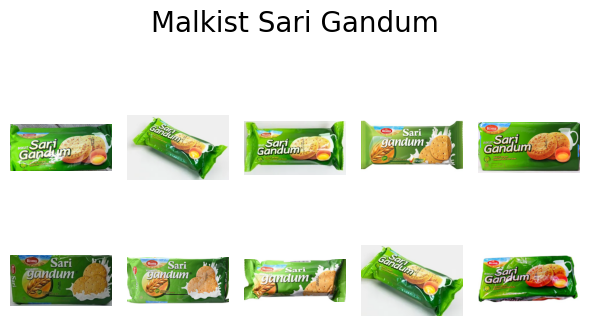

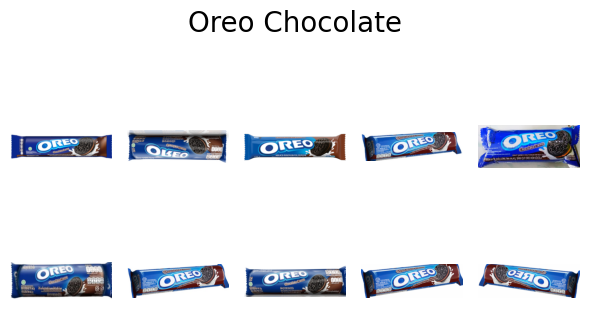

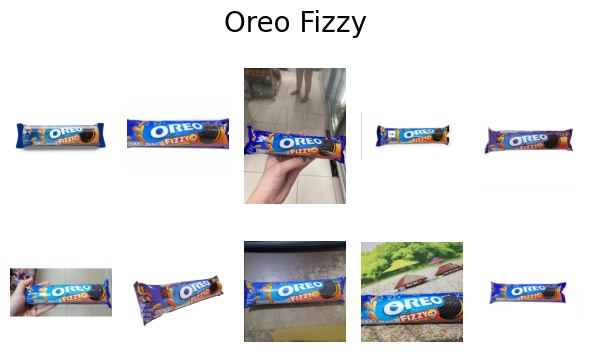

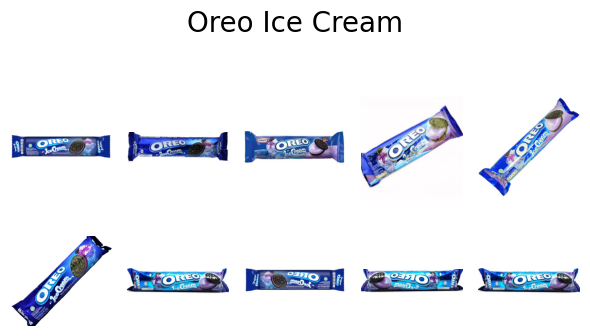

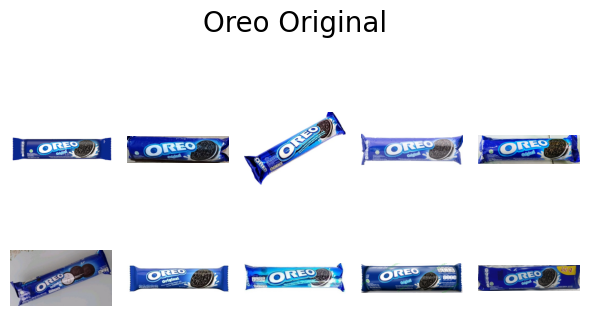

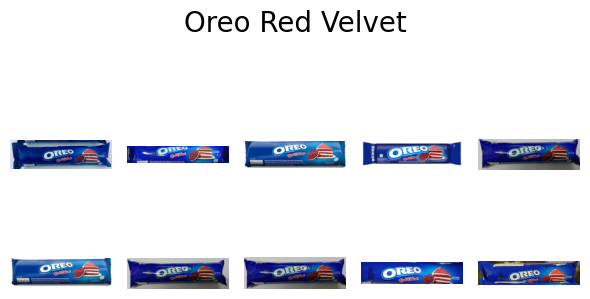

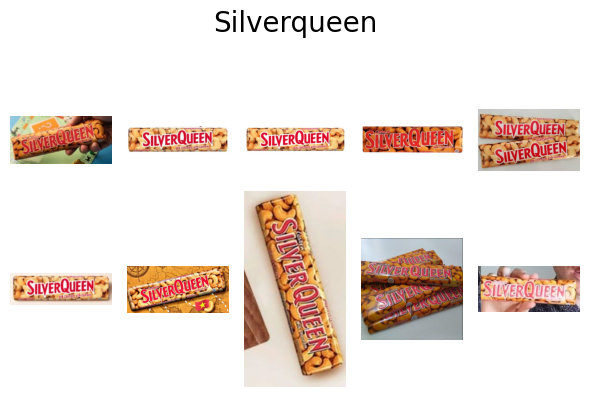

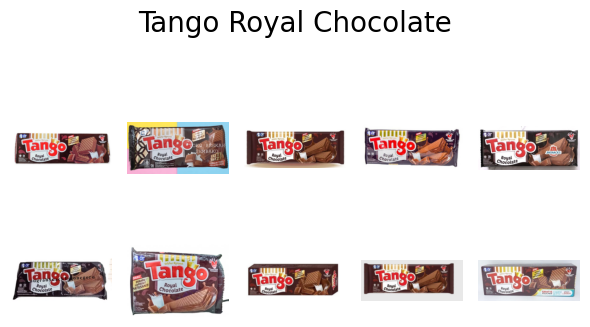

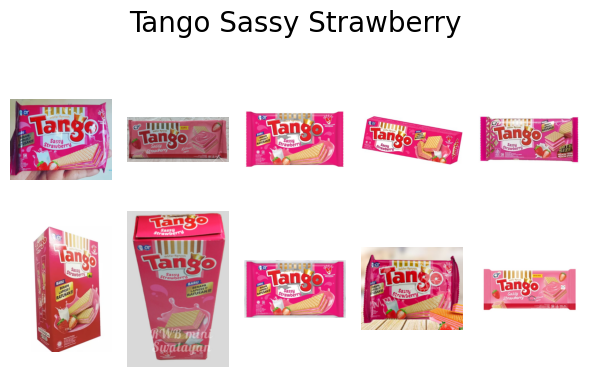

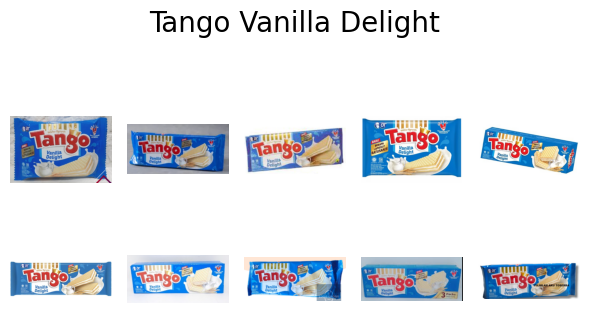

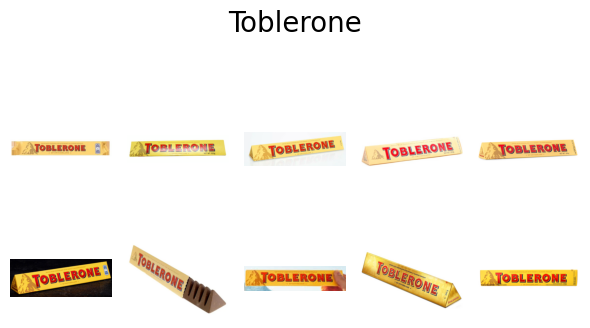

In [2]:
# Function to display images
def display_images(images_dict):
    for biscuit_type, images in images_dict.items():
        plt.figure(figsize=(6, 4))
        plt.suptitle(biscuit_type, fontsize=20)
        for i, image in enumerate(images):
            plt.subplot(2, 5, i + 1)
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

# Display the dataset
display_images(biscuits_images)

## Model

##### Define Pipeline

In [3]:
# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create custom dataset
dataset = BiscuitDataset(biscuits_images, transform=transform)

##### Define data loaders

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


##### Define Model

In [5]:
from transformers import ViTForImageClassification, ViTConfig

# Define model configuration
config = ViTConfig(
    num_labels=21,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    image_size=224,
    patch_size=16
)

# Initialize the model
model = ViTForImageClassification(config)


c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Define Training Loop

In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Assuming your model is already defined as 'model'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Wrap the model with DataParallel
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Training Loss: {total_loss / len(train_loader)}")

        # Validation phase
        model.eval()
        total_correct = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                predictions = torch.argmax(outputs, dim=1)
                total_correct += (predictions == labels).sum().item()
        accuracy = total_correct / len(val_loader.dataset)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device=device)


Training Epoch 1/5: 100%|██████████| 6/6 [01:18<00:00, 13.05s/it]


Training Loss: 2.8076969385147095


Validation Epoch 1/5: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


Validation Accuracy: 26.19%


Training Epoch 2/5: 100%|██████████| 6/6 [01:18<00:00, 13.11s/it]


Training Loss: 2.0523891051610312


Validation Epoch 2/5: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


Validation Accuracy: 33.33%


Training Epoch 3/5: 100%|██████████| 6/6 [01:18<00:00, 13.10s/it]


Training Loss: 1.5967921415964763


Validation Epoch 3/5: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


Validation Accuracy: 42.86%


Training Epoch 4/5: 100%|██████████| 6/6 [01:20<00:00, 13.43s/it]


Training Loss: 1.3347501357396443


Validation Epoch 4/5: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


Validation Accuracy: 54.76%


Training Epoch 5/5: 100%|██████████| 6/6 [01:20<00:00, 13.48s/it]


Training Loss: 1.1488608320554097


Validation Epoch 5/5: 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]

Validation Accuracy: 61.90%


##### Save Model

In [7]:
# Save trained model
model.save_pretrained('trained_vit_biscuit_classifier')

##### Example

In [8]:
from PIL import Image
import torch
from torchvision import transforms

# Load the trained model
model = ViTForImageClassification.from_pretrained('trained_vit_biscuit_classifier')
model.to(device)
model.eval()

# Function to perform inference on a single image
def infer_image(image_path, model, transform, device, label_to_class):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)    
    
    with torch.no_grad():
        outputs = model(image).logits
        predicted_class_idx = outputs.argmax(-1).item()
        predicted_label = label_to_class[predicted_class_idx]
    
    return predicted_label

# Create the label to class mapping
label_to_class = {idx: cls for cls, idx in dataset.class_to_label.items()}

# Path to the new image
image_path = 'biscuits/Tango Vanilla Delight/Tango Vanilla Delight (2).png'

# Perform inference
predicted_label = infer_image(image_path, model, transform, device, label_to_class)
print(f"Predicted Label: {predicted_label}")


Predicted Label: Tango Vanilla Delight


### Convert to onnx format

In [11]:
from safetensors.torch import load_file

# Load the state_dict from the safetensors file
state_dict = load_file('trained_vit_biscuit_classifier/model.safetensors')
model.load_state_dict(state_dict)

# Initialize the model
model = ViTForImageClassification(config)

# Load the state_dict from the safetensors file
state_dict = load_file('trained_vit_biscuit_classifier/model.safetensors')
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for ViTForImageClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([21, 768]) from checkpoint, the shape in current model is torch.Size([5, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([21]) from checkpoint, the shape in current model is torch.Size([5]).

### Convert onnx to tensorflowjs

In [12]:
# Define a dummy input matching the input shape of the model
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model to ONNX
onnx_path = 'model.onnx'
torch.onnx.export(
    model,             # Model being run
    dummy_input,       # Model input (or a tuple for multiple inputs)
    onnx_path,         # Where to save the model
    export_params=True # Store the trained parameter weights inside the model file
)


c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\modeling_vit.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [15]:
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
import tensorflowjs as tfjs

# Load the ONNX model
onnx_model = onnx.load(onnx_path)

# Convert the ONNX model to TensorFlow format
tf_rep = prepare(onnx_model)

# Save the TensorFlow model
tf_model_path = 'tf_model'
tf_rep.export_graph(tf_model_path)

# Convert the TensorFlow model to TensorFlow.js format
tfjs_model_dir = 'tfjs_model'
tfjs.converters.convert_tf_saved_model(tf_model_path, tfjs_model_dir)


ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.16; Detected an installation of version 2.15.1. Please upgrade TensorFlow to proceed.